In [1]:
import helper_functions as hf
import scipy.stats as stats
import sigfig as sf

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import os


In [2]:
tfbsType='AP1'
tfName='AP1'

expname='Tewhey'

tfCore='NTKANNMA'

tfAll8mersPossible=hf.IupacToAllPossibleSequences(tfCore)
tfAll8mersPossible+=[hf.revcomp(seq) for seq in tfAll8mersPossible]


In [3]:
def getAll8mers(seq,p,ref,alt):
    
    altLenAdj=len(ref)-len(alt)
        
    if altLenAdj==0:
        seq=seq[p-7:p+8]    
        seqRef=seq[:7]+ref+seq[7+1:]
        seqAlt=seq[:7]+alt+seq[7+1:]
        
    elif altLenAdj>0:
        seq=seq[p-7:p+8+altLenAdj]    
        seqRef=seq[:7]+ref+seq[7+1:-altLenAdj]
        seqAlt=seq[:7]+alt+seq[7+1:]
    else:
        raise ValueError('ref/alt not allowed yet')
    
    # if len(seqRef)!=len(seqAlt):
        # raise ValueError('ref/alt seqs not dovetailed')
        
    for i,end in enumerate(range(7,len(seq)-altLenAdj)):
        start=end-7
        last=end+1
        kmer8Ref=seqRef[start:last]
        kmer8Alt=seqAlt[start:last]
            
        yield kmer8Ref,kmer8Alt
                    #.  012345678901234567890
            
# for i in getAll8mers(chr2seq['chr7'], 156791183, 'T', ''):
    # print(i)
            

In [4]:
def is_tf_8mer(kmer8):
    if kmer8 in tfAll8mersPossible:                    return True
    else:                                      return False

# Set up logic for creating/deleting ets sites
BeforeAfter2EtsLogic={
    (0,0):'Tf Never',
    (1,1):'Tf Always',
    (0,1):'Tf Created',
    (1,0):'Tf Deleted'
}

In [5]:

def snv_ets_analysis(chrom,idx1,ref,alt,chr2seq,tf2aff):
    
    # Ensure data is snp, no indels
    prohibitedPolyTypes=['Other']
    if len(ref)==1 and len(alt)==1: 
        polymorphismType='SNV'
        
    elif len(ref)==1 and len(alt)==0:
        polymorphismType='SND'
        
    else:
        polymorphismType='Other'
        
    if polymorphismType in prohibitedPolyTypes:
        return 'Variant Type Not Allowed Yet'
        
    ######################################
    # Verify ref/alt matches genomic bp
    ######################################
    
    if 'chr' not in chrom: chrom=f'chr{chrom}'
    
    # Check if pos in genome is same as declared REF
    idx0=int(idx1)-1
    snvNtInGenome=chr2seq[chrom][idx0]
    if ref==snvNtInGenome:    
        checkSnv='REF'
    elif alt==snvNtInGenome:  
        checkSnv='ALT'
    else:                     
        return f'Genomic bp does not match expectation: \n  expected ref/alt = ({ref}/{alt})\n  observed = {snvNtInGenome}'
    
    
    ######################################
    # Assess if SNV is in ETS
    ######################################
    
    etsChanged=False
    for kmer8,kmer8mut in getAll8mers(chr2seq[chrom],idx0,ref,alt):
        core   =kmer8
        coremut=kmer8mut

        ba=(is_tf_8mer(core),is_tf_8mer(coremut)) # before after logic
        etsLogic=BeforeAfter2EtsLogic[ba]

        # If ets-changing snp found, write it out
        if etsLogic=='Tf Always': 
            etsChanged=True
            refaff=tf2aff[kmer8]
            altaff=tf2aff[kmer8mut]
            
            return etsLogic,refaff,altaff,altaff/refaff,kmer8,kmer8mut
        
        elif etsLogic=='Tf Created':
            return etsLogic,kmer8,kmer8mut
            
        elif etsLogic=='Tf Deleted':
            return etsLogic,kmer8,kmer8mut

    if etsChanged==False:
        return 'Variant not in Tf',kmer8,kmer8mut


# Load ref data

In [6]:
# ap1 affinity
ref  =f'preprocessed-data/parsed_Jun_Fos_8mers_core=TGANTMA_max=TGAGTCAT.txt'
Seq2EtsAff  = hf.loadAff(ref)
hf.dprint(Seq2EtsAff)


# hg38
ref=f'/Users/joe/code/ref/genomes/human/hg19/online-only/hg19.fa'
chr2seq=hf.faLoadGenome(ref)

AAAAAAAC 0.28640095325611686


# Load MPRA data

In [7]:
fn='preprocessed-data/tewhey-dataframe-input__fdr__withRC.tsv'
df=pd.read_csv(fn,sep='\t')
df.head(2)

,chrom,pos,ref,alt,effect,log-p,p-value
0,chr1,153588340,C,T,-0.124930,0.803895,0.157074
1,chr1,111642031,A,G,-0.092596,0.102546,0.789685


In [8]:
len(df)

3432

In [9]:
## New one which grabs 8mer ref and  8mer alt  regardlesso f snv  type

variantTypeList=[]
refAffList=[]
altAffList=[]
fcList=[]
ref8merlist=[]
alt8merlist=[]

for idx in df.index:
    
    chrom,pos,ref,alt=[df.at[idx,ci] for ci in ['chrom','pos','ref','alt']]

    if alt=='-': alt=''
    resultList=snv_ets_analysis(chrom,pos,ref,alt,chr2seq,Seq2EtsAff)
    result=resultList[0]
    
    if result=='Variant not in Tf':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Not In Tf')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)


    elif result=='Tf Created':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Tf Created')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)


    elif result=='Tf Deleted':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Tf Deleted')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)

        
    else:
        variantType,refAff,altAff,fc,kmer8ref,kmer8alt=resultList
        variantTypeList.append(variantType)
        refAffList.append(refAff)
        altAffList.append(altAff)
        fcList.append(fc)
        ref8merlist.append(kmer8ref)
        alt8merlist.append(kmer8alt)

        
        
    

In [10]:
df['variant-type']=variantTypeList
df['aff-ref']=refAffList
df['aff-alt']=altAffList
df['aff-fc']=fcList
df['kmer-ref']=ref8merlist
df['kmer-alt']=alt8merlist

df['aff-delta']=df.apply(lambda row: row['aff-alt']-row['aff-ref'],axis=1)

In [11]:
df['variant-type'].value_counts()

Not In Tf     3069
Tf Created     133
Tf Deleted     123
Tf Always      107
Name: variant-type, dtype: int64

In [12]:
# # Replace 0 p value with lowest non-zero p observed
# print('before filter:',df.sort_values('p-value')['p-value'].unique())

# plist=df.sort_values('p-value')['p-value'].unique()
# minP=plist[0]
# minP2=plist[1]

# print('\n\n',minP,minP2)

# df['p-value']=df['p-value'].apply(lambda p: p if p>0 else minP2)

# print('after filter:',df.sort_values('p-value')['p-value'].unique())

In [13]:
df['-log(p)']=df['log-p'].apply(lambda logp: logp)
df['-log(p)*direction']=df.apply(lambda r: r['-log(p)'] if r['effect']>=0 else -r['-log(p)'],axis=1)

In [14]:
df['variant-type'].value_counts()

Not In Tf     3069
Tf Created     133
Tf Deleted     123
Tf Always      107
Name: variant-type, dtype: int64

In [15]:
df['chrompos']=df['chrom']+df['pos'].apply(str)
print(len(df['chrompos']))
print(len(df['chrompos'].unique()))

3432
3222


In [16]:
# some rsids are present twice. Prioritize keeping the tested variant which is significant. If significant in both direction (gof and lof), then do not use

logp5=-np.log10(.05)

duplicateChrompos  = [cp for cp in df['chrompos'].unique() if df['chrompos'].tolist().count(cp)>1]
len(duplicateChrompos)

keepIndices=[]
duplicateChromposConsidered=[]

nomit=0

for idx in df.index:
    
    cp=df.at[idx,'chrompos']
    
    # if index not a duplicate, simply keep the index
    if cp not in duplicateChrompos:
        keepIndices.append(idx)
        duplicateChromposConsidered.append(cp)
        
    # if you've already analyzed this cp, then skip
    elif cp in duplicateChromposConsidered:
        continue
    
    # if duplicate and haven't seen, choose one of the dups to keep
    else:
        r1,r2=df.loc[df['chrompos']==cp,'-log(p)*direction'].tolist()
        
        r1isgof = r1>logp5
        r2isgof = r2>logp5
        
        r1islof = r1<-logp5
        r2islof = r2<-logp5
        
        r1isns  = (not r1isgof) and (not r1islof)
        r2isns  = (not r2isgof) and (not r2islof)
        
        # if BOTH gof, keep r1
        if r1isgof and r2isgof:
            idxkeep=df.loc[df['chrompos']==cp,:].index.tolist()[0]
            keepIndices.append(idxkeep)
            
        # if ONE is sig... one is n.s.
        #          ... where r1 is significant
        elif ((r1isgof or r1islof) and r2isns):
            idxkeep=df.loc[(df['chrompos']==cp) & (df['-log(p)*direction']==r1),:].index.tolist()[0]
            keepIndices.append(idxkeep)
            
        #          ... where r2 is significant
        elif ((r2isgof or r2islof) and r1isns):
            idxkeep=df.loc[(df['chrompos']==cp) & (df['-log(p)*direction']==r2),:].index.tolist()[0]
            keepIndices.append(idxkeep)
            
        # if NEITHER sig, keep r1
        elif r1isns and r2isns:
            idxkeep=df.loc[df['chrompos']==cp,:].index.tolist()[0]
            keepIndices.append(idxkeep)
            
        # OTHERWISE (one sig gof, other is sig lof), omit
        else:
            nomit+=1
            continue
            
print('num omitted',nomit)
print('num kept',len(keepIndices))

df=df.loc[keepIndices,:]

num omitted 28
num kept 3404


In [17]:
print(len(df))
df=df.drop_duplicates()
print(len(df))

3404
3208


# Prediction accuracy vs random (for nature)

In [18]:
pvalCutoff=.05
logSigCutoff=abs(np.log10(pvalCutoff))

deNovoThresh=.25

fcOptCutoff=1.5
fcDecCutoff=sf.round(1/fcOptCutoff,3)

fcNoChangeCutoff_Inc=1.25
fcNoChangeCutoff_Dec=sf.round(1/fcNoChangeCutoff_Inc,3)



# get variants to predict on
predDF=df.loc[:,:]

# assign prediction labels
bins=[-np.inf,-logSigCutoff,logSigCutoff,np.inf]
predDF['classification']=pd.cut(predDF['-log(p)*direction'],bins=bins,labels=['Sig Decrease','N.S.','Sig Increase'])

# assign predictions
etsLabels=[]

for fc,classification,kmer,kmerMut in hf.zipdf(predDF,['aff-fc','variant-type','kmer-ref','kmer-alt']):

    # not in tf
    if classification=='Not In Tf':
        anno='not-in-tf'

    # delet tf
    elif classification=='Tf Deleted':
        anno='del-tf'

    elif classification=='Tf Created':

        denovoaff=Seq2EtsAff[kmerMut]

        if denovoaff<deNovoThresh:
            anno=f'de-novo-tf-low-aff\n<{deNovoThresh}'            

        elif denovoaff>=deNovoThresh:
            anno=f'de-novo-tf-high-aff\n>={deNovoThresh}'

    #  dramatic iincrase
    elif fc>=fcOptCutoff:
        anno=f'dramatic-increase\n>={fcOptCutoff}'

    #  dramatic incrase
    elif fc<=fcDecCutoff:
        # print(fc,classification)
        anno=f'dramatic-decrease\n<={fcDecCutoff}'

    # no increase
    elif fc<=fcNoChangeCutoff_Inc and fc>=fcNoChangeCutoff_Dec:
        anno=f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}'

    else:
        # print(fc,classification,kmer,kmerMut)
        anno='subtle-change'


    etsLabels.append(anno)

predDF['tf-class']=etsLabels

line_out=hf.write_row(['snv-group','total','effect-ns','effect-gof','effect-lof'])

for classi in predDF['tf-class'].unique():
    nClassi=predDF['tf-class'].value_counts()[classi]

    ns,gof,lof=[predDF.loc[predDF['tf-class']==classi,'classification'].value_counts()[ci] for ci in ['N.S.','Sig Increase','Sig Decrease']]

    line_out+=hf.write_row([classi.replace('\n',' '),nClassi,ns,gof,lof])

print(line_out)
with open(f'FOR-NATURE-STATS-PREDICTIONS-{expname}-{tfName}__fdr.tsv','w') as f: f.write(line_out)

snv-group	total	effect-ns	effect-gof	effect-lof
not-in-tf	2862	2193	321	348
de-novo-tf-low-aff <0.25	16	8	6	2
no-change-aff <=1.25 >=0.8	68	49	5	14
del-tf	120	84	6	30
subtle-change	17	13	2	2
de-novo-tf-high-aff >=0.25	111	78	25	8
dramatic-decrease <=0.667	6	3	1	2
dramatic-increase >=1.5	8	2	6	0



/Users/joe/miniconda3/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


group1	group2	p
not-in-tf+del-tf+dramatic-decrease <=0.667+de-novo-tf-low-aff <0.25+de-novo-tf-high-aff >=0.25+subtle-change	no-change-aff <=1.25 >=0.8	0.7887
not-in-tf+del-tf+dramatic-decrease <=0.667+de-novo-tf-low-aff <0.25+de-novo-tf-high-aff >=0.25+subtle-change	dramatic-increase >=1.5	0.002118



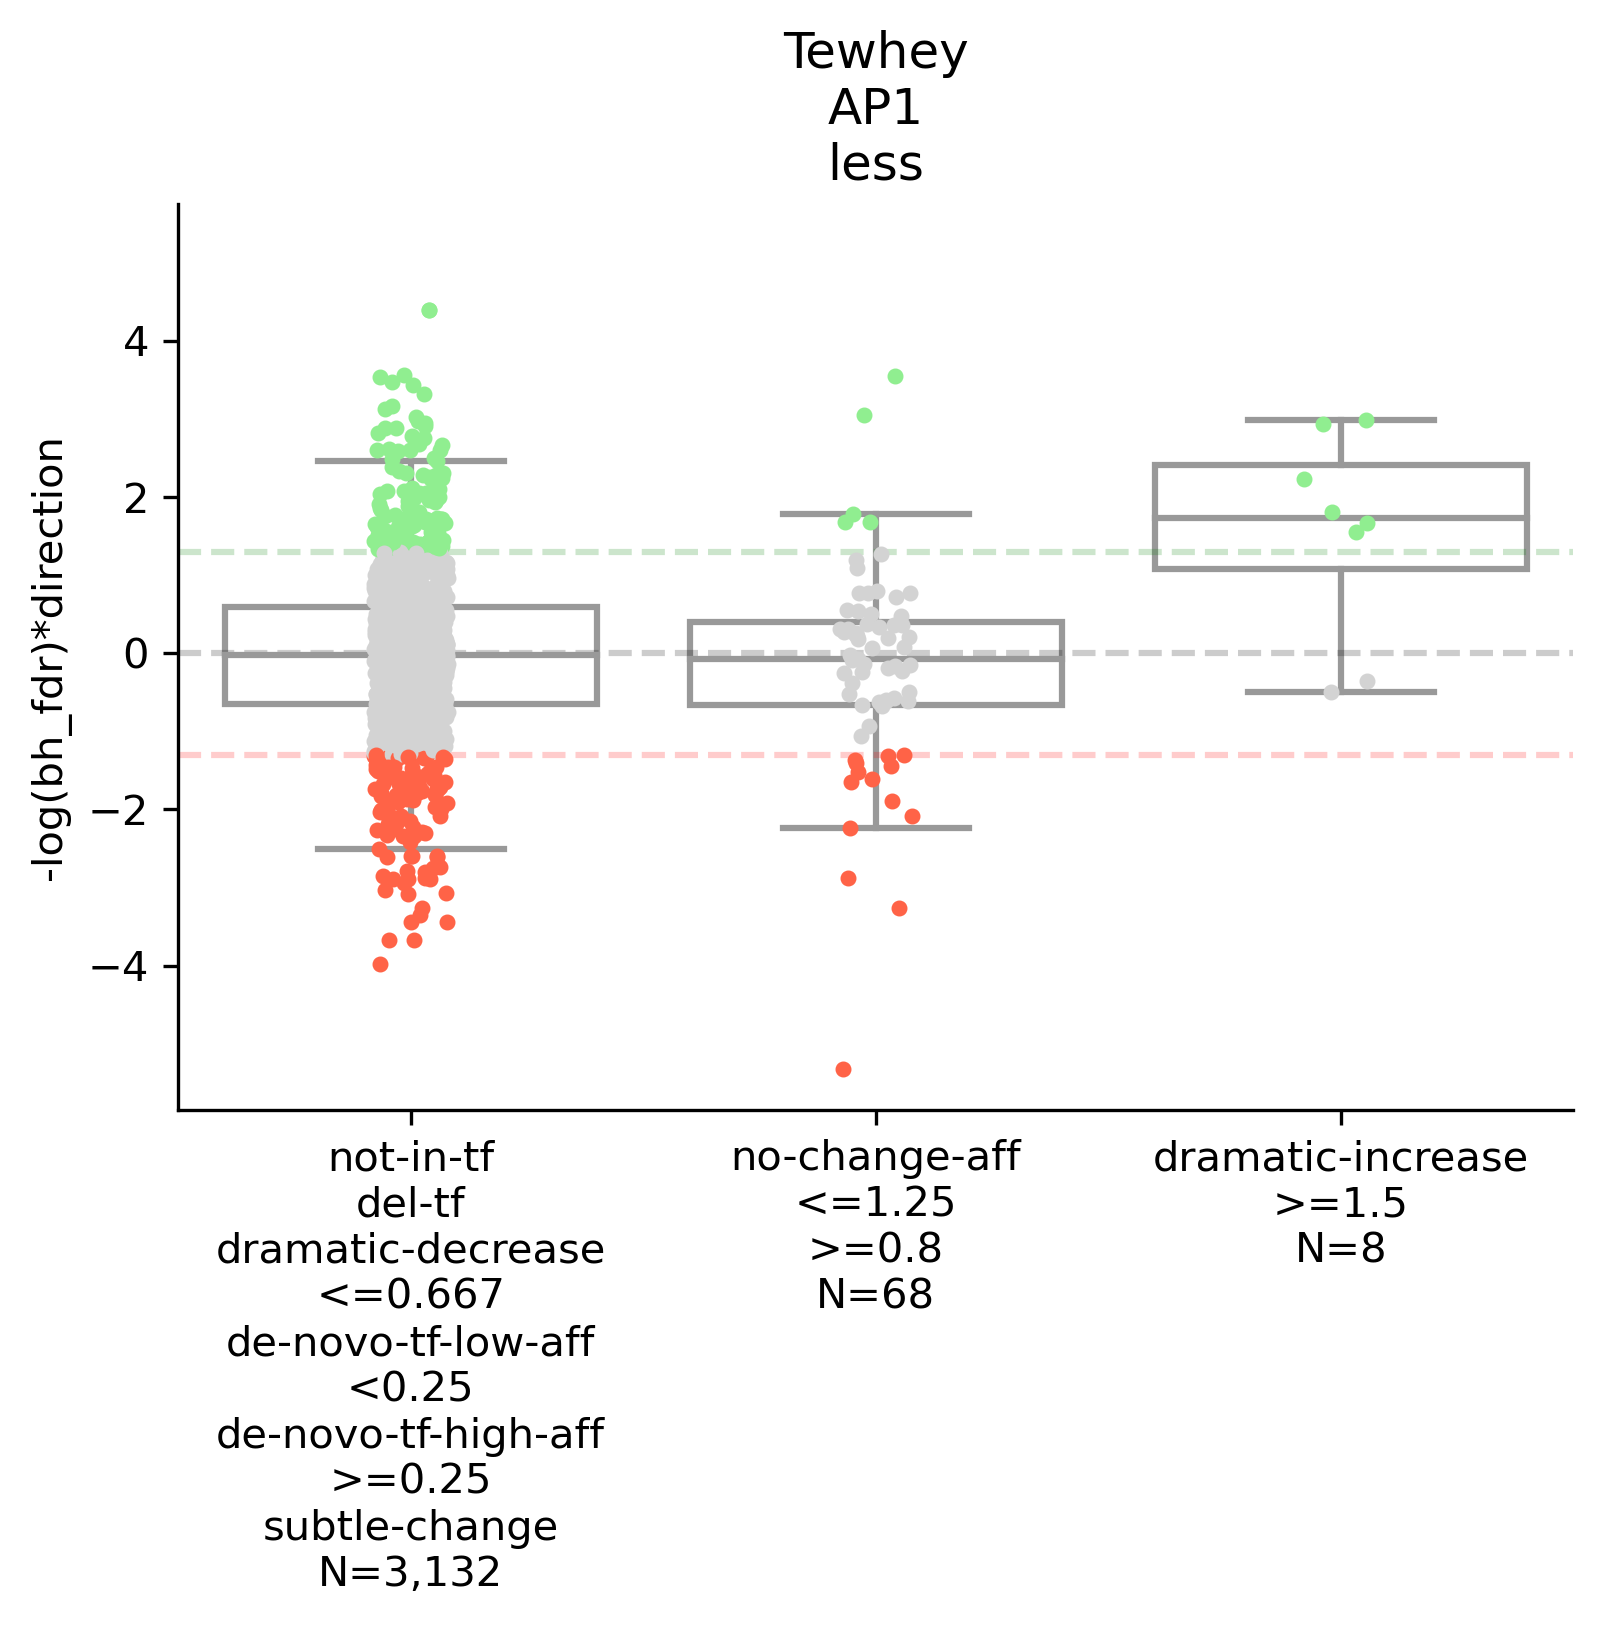

In [19]:
altHypothesis='less'

violin=False
boxplot=True

datalabels_subset_v2=[
[f'not-in-tf',f'del-tf',f'dramatic-decrease\n<={fcDecCutoff}',f'de-novo-tf-low-aff\n<{deNovoThresh}',f'de-novo-tf-high-aff\n>={deNovoThresh}','subtle-change'],
[f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}'],
[f'dramatic-increase\n>={fcOptCutoff}'],
]

data2color={
(f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}',):'lightgrey',
(f'dramatic-increase\n>={fcOptCutoff}',):'forestgreen',
(f'not-in-tf',f'del-tf',f'dramatic-decrease\n<={fcDecCutoff}',f'de-novo-tf-low-aff\n<{deNovoThresh}',f'de-novo-tf-high-aff\n>={deNovoThresh}','subtle-change'):'dimgrey'}

plotDF=predDF.loc[:,:]




data=[]
for di in datalabels_subset_v2:
    datai=[]
    for dj in di:
        datai+=plotDF.loc[(plotDF['tf-class']==dj),'-log(p)*direction'].tolist()
    data.append(datai)

line_out=hf.write_row(['group1','group2','p'])

############################################################################
# Stats
############################################################################

dCtrlNameList=datalabels_subset_v2[0]
dCtrl=plotDF.loc[(plotDF['tf-class'].isin(dCtrlNameList)),'-log(p)*direction']

for diNameList in datalabels_subset_v2[1:]:

    di=plotDF.loc[(plotDF['tf-class'].isin(diNameList)),'-log(p)*direction']

    try:
        _ , p =stats.mannwhitneyu(dCtrl,di,alternative=altHypothesis)
    except ValueError:
        pass


    line_out+=hf.write_row(['+'.join(dCtrlNameList).replace('\n',' '),'+'.join(diNameList).replace('\n',' '),sf.round(p,4)])

print(line_out)
with open(f'FOR-NATURE__violin-stats__{tfName}__{expname}.tsv','w') as f: f.write(line_out)

############################################################################
# Stats
############################################################################

fig,ax=hf.quickfig(2*len(datalabels_subset_v2),4,dpi=300)

palette=[data2color[tuple(di)] for di in datalabels_subset_v2]

if violin:
    sns.violinplot(data=data,color='white',inner=None,cut=0,ax=ax,width=1.1,scale='area')

if boxplot:
    sns.boxplot(data=data,color='white',ax=ax,fliersize=0)#,palette=palette)

lc=0
for xi,di in enumerate(data):
    for lc, yi in enumerate(di):
        if lc>1000: break
        xjittermax=.08
        xijitter=np.random.uniform(-xjittermax,xjittermax)
        if yi>=logSigCutoff:            color='lightgreen'
        elif yi<=-logSigCutoff:          color='tomato'
        else:                           color='lightgrey'

        ax.scatter(xijitter+xi,yi, color=color,s=8,zorder=100,alpha=1)#,cut=0) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

axticklabels=['\n'.join(label) for label in datalabels_subset_v2]
ax.set_xticklabels([f'{label}\nN={len(points):,}' for label,points in zip(axticklabels,data)])
ax.set_ylabel('-log(bh_fdr)*direction')

ax.axhline(-np.log10(.05),ls='--',color='green',alpha=.2)
ax.axhline(np.log10(.05),ls='--',color='red',alpha=.2)
ax.axhline(np.log10(1),ls='--',color='black',alpha=.2)

ax.set_title(f'{expname}\n{tfName}\n{altHypothesis}')


# plt.savefig(f'/Users/joe/Desktop/ets-kircher-elements={idList}.png')# ,bbox_inches='tight')
plt.show()
       

plotDF.to_csv(f'NATURE-ALL-DATA_{tfName}_{expname}.tsv',sep='\t',index=None)

